# LOW RANK ALGORITHMS FOR HEAT EQUATION IN 2D & 3D

The goal of this notebook is to compute the heat equation in 2D & 3D, while applying low rank algorithm to the Euler scheme

__Sources__ 

For the theory part we use : 

1) _Excerpt from GEOL557 Numerical Modeling of Earth Systems by Becker and Kaus (2016)_
http://geodynamics.usc.edu/~becker/teaching/557/problem_sets/problem_set_fd_2dheat.pdf

For the low rank part we use : 

2) _Streaming Low-Rank Matrix Approximation with an Application to Scientific Simulation_
Joel A. Tropp, Alp Yurtsever, Madeleine Udell, Volkan Cevher
https://arxiv.org/pdf/1902.08651.pdf

## Heat equation in 2D ##

We start by importing the necessary librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 6, 4
from celluloid import Camera
from scipy.linalg import expm, sinm, cosm
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tensorly import unfold, fold, vec_to_tensor
from tensorly.tenalg import mode_dot, khatri_rao, kronecker

## Heat equation in 2D ##

We want to compute the **Heat equation in 2D**

We want to compute 


$\rho c_{p} \frac{\partial T}{\partial t}=\frac{\partial}{\partial x}\left(k_{x} \frac{\partial T}{\partial x}\right)+\frac{\partial}{\partial z}\left(k_{z} \frac{\partial T}{\partial z}\right)+Q$

where, $\rho$ is density, $c_{p}$ heat capacity, $k_{x, z}$ the thermal conductivities in $x$ and $z$ direction, and $Q$ radiogenic heat production.

We suppose that $k_{x}=k_{z}$

then we have : 
$\frac{\partial T}{\partial t}=\kappa\left(\frac{\partial^{2} T}{\partial x^{2}}+\frac{\partial^{2} T}{\partial z^{2}}\right)+\frac{Q}{\rho c_{p}}$

Discretizing our plane we have : 

$\frac{T_{i, j}^{n+1}-T_{i, j}^{n}}{\Delta t}=\kappa\left(\frac{T_{i, j+1}^{n}-2 T_{i, j}^{n}+T_{i, j-1}^{n}}{(\Delta x)^{2}}+\frac{T_{i+1, j}^{n}-2 T_{i, j}^{n}+T_{i-1, j}^{n}}{(\Delta z)^{2}}\right)+\frac{Q_{i, j}^{n}}{\rho c_{p}}$

but as $(\Delta x)^{2}=(\Delta z)^{2}$

we obtain after rearranging the sum : 

$T_{i, j}^{n+1}=T_{i, j}^{n}+s\left(T_{i, j+1}^{n}+T_{i, j-1}^{n}-4 T_{i, j}^{n}+T_{i-1, j}^{n}+T_{i+1, j}^{n}\right)+\frac{Q_{i, j}^{n} \Delta t}{\rho c_{p}}$

where $s=\frac{\kappa \Delta t}{(\Delta x)^{2}}=\frac{\kappa \Delta t}{(\Delta z)^{2}}$

We need to have 

$\frac{2 \kappa \Delta t}{\min \left((\Delta x)^{2},(\Delta z)^{2}\right)} \leq 1$ to get a stable explicit forward scheme

**We start by creating the base of the equation (discretization of the plane and constant)**

We want to look at the domain $[0,1]\times[0,1]$ with these constants with each m=20 points in each direction (which means $\Delta x=\Delta z=0.05$). 

We take :

$\Delta t = 0.01$

$\kappa = 0.05$

$\rho = 0.5$

$c_{p} = 0.8$

$s=\frac{\kappa \Delta t}{(\Delta x)^{2}}$

In [2]:
dt=0.01
m=20
k=0.05
rho=0.5
c=0.8
dx=1/m
dy=1/m
s=k*dt/dx**2

_A quick verification to see if this scheme will be stable_

In [3]:
(2*k*dt)/dx**2

0.3999999999999999

By rewriting the sum 

$T_{i, j}^{n+1}=T_{i, j}^{n}+s\left(T_{i, j+1}^{n}+T_{i, j-1}^{n}-4 T_{i, j}^{n}+T_{i-1, j}^{n}+T_{i+1, j}^{n}\right)+\frac{Q_{i, j}^{n} \Delta t}{\rho c_{p}}$

as vectors and matrix we obtain

$\underline{u}^{n+1}=\underline{u}^{n}+s*A\underline{u}^{n}+\underline{c}$

Where $\underline{u}^{n+1}$ is the vector of the solution at the time n+1, $\underline{u}^{n}$ is a vector with the solution at $n$, $A$ is a matrice and $c$ is a vector (see source [1] for more details).

For $A$, we create a function **operator** which will return the matrix of dimension $m^2\times m^2$ (we need to create a function **tridiag**, which allows to create  a tridiagonal matrix)

In [4]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def operator(n):
    I=np.identity(n)
    
    a=1*np.ones(n-1) ; b=-4*np.ones(n) ; c=a

    T_E=tridiag(a,b,c)
    T_I=tridiag(a,b-b,a)

    D=np.kron(I, T_E)+np.kron(T_I, I)
    
    return(D)

A=operator(m)

We set $\underline{c}$ to 0 for simplicity

For $\underline{u}^{0}$, we first define the initial conditions on our plane represented as a matrix, we then flatten this matrix to obtain the vector  $\underline{u}^{0}$

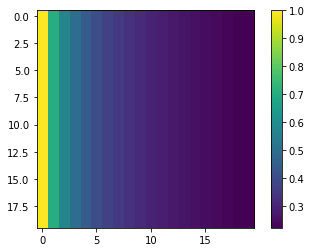

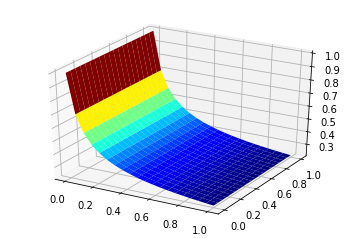

In [5]:
U0=[1/np.sqrt(i+1) for i in range(m)] #initial condition
U0=np.tile(U0,(len(U0),1))

#---------------------------show the map

plt.imshow(U0);
plt.colorbar()
plt.show()

X=np.linspace(0,1,m)
Y=X

X,Y=np.meshgrid(X,Y)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, U0, cmap='jet')

We now create a function that will do the following scheme : 
    
    
$\underline{u}^{n+1}=\underline{u}^{n}+s*A*\underline{u}^{n}$

In [6]:
def LaplacianExact(U,t_int,xy_int,nt,nxy,s):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time interval, nxy is the number of element in one nxy direction
    #s is the constant s
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    sol=[]
    
    sol.append(U)
    
    size=U.shape
    
       
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator(n)
    
    #------------------------------------Euler
    
  
    for i in range(nt):
        
        U=U.flatten('F') 
        
        U=U+s*D@U
                
        dU=np.reshape(U,size,order='F')
                
        sol.append(dU)
        
        U=dU
        
    
    return sol

We now test how it is working for at time interval of $[0,1]$ with $n$ points to insure stability in function of $\Delta t$

In [7]:
t_int=[0,1]
xy_int=[0,1]
nt=int((t_int[1]-t_int[0])/dt)
nxy=m
sol=LaplacianExact(U0,t_int,xy_int,nt,nxy,s)

Plotting the result we obtain

Text(0.5,0.92,'Exact solution at t=15 ')

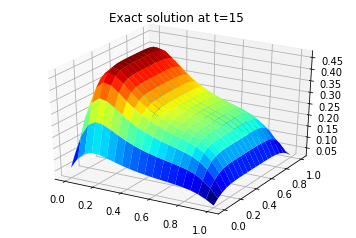

In [8]:
Z=sol[15]
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
plt.title('Exact solution at t=15 ')

We can animate it to see how the plane get cold

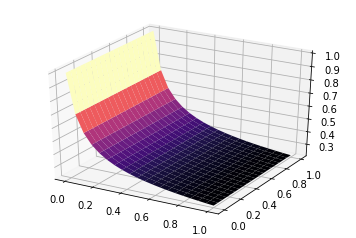

In [9]:
frn=nt #frame must be equal of the number of solution we have
fps=10 #frame per minutes

#-------------- creating a tensor containing the frame

zarray=np.zeros((m,m,nt))

for i in range(nt):
    zarray[:,:,i]=sol[i]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

plt.rcParams['animation.html'] = 'html5'
ani

We now want to approximate this solution by low rank projector algorithm.
We will use the principal algorithm in source 2, calling it **STA19**

This algorithm take an input matrix $A$, reduce it by _dimention reduction map_ (map that reduce the dimension of a matrix will preserving the distance on average), then truncate the obtained matrix by aplying an SVD and choosing an aimed rank $r$. The solution is a matrix of rank $r$ which approximate the input matrix $A$. 

In [16]:
def sta_algo(r,A,k,s):
    #INPUTS:
    #r : truncated final rank
    #A : matrix to approximate (MxN)
    #Dim_redux : (KxM), (KxN), (SxM), (SxN)
    #OUTPUTS : 
    #A_tilda : approximate matrix of rank r0
    #////plan
    #1. recuperation of the dim_red from the array
    #2. capturing the range, corange, and the new whole 
    #3. qr to get the orthonormal matrix
    #4. least square
    #5. reconstruct the svd after troncature
    #6. reconstruction
    
    #1. recuption of the dim_red from the array and initiation of X,Y,Z,W
    #(KxM), (KxN), (SxM), (SxN)
    
    m,n =A.shape
    Y_=np.random.randn(k,m) ; Ω=np.random.randn(k,n) ; Φ=np.random.randn(s,m) ; Ψ=np.random.randn(s,n)
    
    #2. capturing the range, corange, and the new whole 
    
    X=Y_@A ; Y=A@Ω.conj().T ; Z=Φ@A@(Ψ.conj().T) ; 
    
    #3. qr 
    
    Q=np.linalg.qr(Y)[0] ; P=np.linalg.qr(X.conj().T)[0]
    U1, T1 = np.linalg.qr(Φ@Q) ; U2,T2 = np.linalg.qr(Ψ@P)
    
    
    #4. least square
    
    C=np.linalg.lstsq(T1,U1.conj().T@Z@U2, rcond=None)[0]
    C=(np.linalg.lstsq(T2,C.conj().T, rcond=None)[0]).conj().T

    

    
    #5. troncated svd + consolidation
    
    S, D, Vt=np.linalg.svd(C, full_matrices=True)
    S=S[:,0:r] ; D=np.diag(D[0:r]) ; Vt=Vt[0:r,:]
    S=Q@S ; Vt=Vt@(P.conj().T)
    
    #6. reconstruction
    
    Trunc_svd=[S,D,Vt]
    A_tilda=S@D@Vt
    
    return(A_tilda, Trunc_svd)

As before, we create a function to apply the recurrence

In [17]:
def Laplacian_Euler_sta_random(U,t_int,xy_int,nt,nxy,r,k,s,f):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #r is the rank and k,s are the elements used in the STA algorithm, f is the matrice constant
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    A=sta_algo(r,U,k,s)[0]
    
    sol=[]
    
    U=A
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator(n)
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=U.flatten('F') 
        
        U=U+f*D@U
        
        dU=np.reshape(U,size,order='F')
        
        dU=sta_algo(r,dU,k,s)[0]
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

We now want to look at the result obtained by this algorithm, compared to the solution we obtain by a standard Euler. 

To do so, we plot the difference and animate it. 

We troncate at the rank $r=3$, with dimension reduction map with parameter $6$ and $12$

In [18]:
f=s
sol_random=Laplacian_Euler_sta_random(U0,t_int,xy_int,nt,nxy,3,6,12,f)

zarray=np.zeros((m,m,nt))

for i in range(nt):
    zarray[:,:,i]=abs(sol_random[i]-sol[:,:,i])

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

plt.rcParams['animation.html'] = 'html5'
ani

TypeError: list indices must be integers or slices, not tuple

We want to compare the error for different ranks between a standard SVD troncation and the other algorithm, and plot the result. We use a relative error where the "exact matrix" is the matrix obtained by the standard Euler Scheme.

First we define the algorithm with a standard troncated SVD.

In [19]:
def svd_r(A,r):
    #INPUTS : 
    #A = matrix to troncate
    #r = rank 
    #OUTPUT : 
    #M = matrix final 
    
    U,D,Vt = np.linalg.svd(A, full_matrices=True)
    U=U[:,0:r] ; Vt=Vt[0:r,:] ; D=np.diag(D[0:r])
    finale=U@D@Vt
    
    return(finale)

In [20]:
def Laplacian_Euler_svd_random(U,t_int,xy_int,nt,nxy,r,f):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #r is the rank , f is the operator matrix
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U=svd_r(U,r)
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator(n)
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=U.flatten('F') 
        
        U=U+f*D@U
        
        dU=np.reshape(U,size,order='F')
        
        dU=svd_r(dU,r)
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

HMT11

In [21]:
def hmt_fixed_r(M,r,k,q):
    #INPUTS : 
    #M = Matrix MxN to approximate
    #r = final rank
    #k = dim redux size
    #q = parameter (0,1,2)
    #OUTPUTS : 
    #M_r = Matrix with approximated rank
    #U_r = troncated singular vector matrix
    
    m=M.shape[0]
    n=M.shape[1]

    Omega=np.random.randn(n,k)
    
    if q==0:
        
        Y=M@Omega
    
    if q==1:
        
        Y=M@(M.conj().T@(M@Omega))
        
    if q==2:
        
        Y=M@(M.conj().T@(M@(M.conj().T@(M@Omega))))
             
    Q,R=np.linalg.qr(Y)
        
    B=Q.conj().T@M
        
    U,D,Vh=np.linalg.svd(B,full_matrices=True)
    
    U=U[:,0:r]
    
    D=D[0:r]
    
    Vh=Vh[0:r,:]

    U=Q@U
        
    M_r=U@np.diagflat(D)@Vh
        
    U_r=U
    
    return(M_r,U_r)

In [22]:
def Laplacian_Euler_hmt11_random(U,t_int,xy_int,nt,nxy,r,f,k,p):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #r is the rank , f is the operator matrix, k&p are the parameters for the low rank algorithm
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U=hmt_fixed_r(U,r,k,p)[0]
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator(n)
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=U.flatten('F') 
        
        U=U+f*D@U
        
        dU=np.reshape(U,size,order='F')
        
        dU=hmt_fixed_r(dU,r,k,p)[0]
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

TCYU17

In [23]:
def tcyu(M,r,k,l):
    #INPUTS : 
    #M = matrix to approximate
    #r = wanted rank
    #k,l = k<=l (parameter)
    #OUTPUTS : 
    #M_tilde = wanted matrix
    
    m=M.shape[0]
    n=M.shape[1]
    
    Y_tilde=np.random.randn(l,m)
    Ω=np.random.randn(k,n)
    
    X=Y_tilde@M
    Y=M@(Ω.conj().T)
    
    Q, R=np.linalg.qr(Y)
    
    B=np.linalg.lstsq(Y_tilde@Q, X,rcond=None)[0]
    
    U, D, Vh = np.linalg.svd(B, full_matrices=True)
    
    U=U[:,0:r] ; D=D[0:r] ; Vh=Vh[0:r,:]
    
    Q_tilde=Q@U
    
    M_tilde=U@np.diagflat(D)@Vh
    
    M_tilde=Q@M_tilde
    
    return(M_tilde,Q_tilde)

In [24]:
def Laplacian_Euler_tcyu17_random(U,t_int,xy_int,nt,nxy,r,f,k,s):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #r is the rank , f is the operator matrix, k&s are the parameters for the low rank algorithm
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U=tcyu(U,r,k,s)[0]
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator(n)
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=U.flatten('F') 
        
        U=U+f*D@U
        
        dU=np.reshape(U,size,order='F')
        
        dU=tcyu(dU,r,k,s)[0]
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

We define a function to transform a list to a tensor

In [25]:
def list_to_tensor(list):
    #INPUT : 
    #list : list to transform
    #OUTPUT : tensor
    
    length=len(list)
    dim=list[0].shape
    T=np.zeros((dim[0],dim[1],length))
    for i in range(length):
        T[:,:,i]=list[i]
        
    return T

In [26]:
f=s
result_sta=[]
result_svd=[]
result_hmt11=[]
result_tcyu=[]
rarray=[]

for r in range(2,10):
    sol_random=list_to_tensor(Laplacian_Euler_sta_random(U0,t_int,xy_int,nt,nxy,r,r+2,r*2+2,f))
    sol_svd=list_to_tensor(Laplacian_Euler_svd_random(U0,t_int,xy_int,nt,nxy,r,f))
    sol=list_to_tensor(LaplacianExact(U0,t_int,xy_int,nt,nxy,s))
    sol_hmt11=list_to_tensor(Laplacian_Euler_hmt11_random(U0,t_int,xy_int,nt,nxy,r,f,r+2,0))
    sol_tcyu17=list_to_tensor(Laplacian_Euler_tcyu17_random(U0,t_int,xy_int,nt,nxy,r,f,r+2,r*2+2))
    
    sta_result=np.linalg.norm(sol_random-sol)/np.linalg.norm(sol)
    svd_result=np.linalg.norm(sol_svd-sol)/np.linalg.norm(sol)
    hmt11_result=np.linalg.norm(sol_hmt11-sol)/np.linalg.norm(sol)
    tcyu_result=np.linalg.norm(sol_tcyu17-sol)/np.linalg.norm(sol)
    
    result_svd.append(svd_result)
    result_sta.append(sta_result)
    result_hmt11.append(hmt11_result)
    result_tcyu.append(tcyu_result)
    rarray.append(r)

Text(0.5,1,'Relative error for target rank $r$')

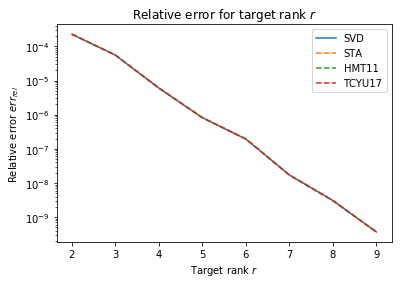

In [27]:
plt.semilogy(rarray, result_svd,label='SVD')
plt.semilogy(rarray, result_sta,'--',label='STA')
plt.semilogy(rarray, result_hmt11,'--',label='HMT11')
plt.semilogy(rarray, result_tcyu,'--',label='TCYU17')
plt.legend()
plt.xlabel('Target rank $r$')
plt.ylabel('Relative error $err_{rel}$')
plt.title('Relative error for target rank $r$')

And then we plot the result

Text(0.5,1,'Decay of the singular values')

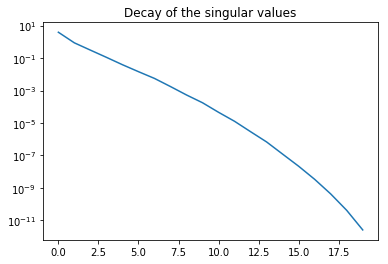

In [28]:
plt.semilogy(np.linalg.svd(sol[0])[1])
plt.title('Decay of the singular values')

## Heat equation in 3D 

We are now interested in computing

$T_{i, j, k}^{n+1}=T_{i, j, k}^{n}+s\left(T_{i, j+1, k}^{n}+T_{i, j, k-1}^{n}+T_{i, j-1, k}^{n}-6 T_{i, j, k}^{n}+T_{i-1, j, k }^{n}+T_{i+1, j, k}^{n}+T_{i, j, k+1}^{n}\right)+\frac{Q_{i, j, k}^{n} \Delta t}{\rho c_{p}}$

where $s=\frac{\kappa \Delta t}{(\Delta x)^{2}}=\frac{\kappa \Delta t}{(\Delta z)^{2}}=\frac{\kappa \Delta t}{(\Delta y)^{2}}$

We use the same constant as before, except changing the distance between each point at 0.1 (easier to plot)

We look at the domain $[0,1]\times[0,1]\times[0,1]$ with these constants with each m=20 points in each direction (which means $\Delta x=\Delta z=\Delta y=0.1$). 

We take :

$\Delta t = 0.01$

$\kappa = 0.001$ <- this line has change to make the resolution stable

$\rho = 0.5$

$c_{p} = 0.8$

$s=\frac{\kappa \Delta t}{(\Delta x)^{3}}$ <- this line has change too

In [29]:
dt=0.01
m=20
k=0.001
rho=0.5
c=0.8
dx=1/m
dy=1/m
s=k*dt/dx**3

Testing the stability we have

In [30]:
(2*k*dt)/dx**3

0.15999999999999998

What will change is that the domain is in 3D, we then need a new discrete operator and the initial values will be in a tensor. 

We need a new operator : 

In [31]:
m=10

def operator3d(n):
    I=np.identity(n)
    J=np.identity(n**2)
    
    a=1*np.ones(n-1) ; b=-6*np.ones(n) ; c=a

    T_E=tridiag(a,b,c)
    T_I=tridiag(a,b-b,a)

    D=np.kron(I, T_E)+np.kron(T_I, I)
    
    D=np.kron(I,D)+np.kron(T_I,J)
    
    return(D)

A=operator3d(m)

We create to function to flatten the tensor and reshaping it.
We could also use np.flatten(U,'F') and np.reshape(U,size,'F')

In [32]:
def tensorFlatten(T):
    #Input : Given a tensor T, flatten the tensor
    #Output : Vector
    
    a=T[0].flatten('F')
    j=T.shape
    for i in range(1,j[2]):
        a=np.hstack((a,T[i].flatten('F')))
        
    return(a)

def tensorReshape(vec,size):
    #reshape a tensor from a vector
    A=np.zeros(size)
    for i in range(size[2]):
        A[i]=np.reshape(vec[i*(size[0]*size[1]):(i+1)*size[0]*size[1]],(size[0],size[1]),'F')
    
    return(A)

We also need to change the Solver

In [33]:
def LaplacianExact3d(U,t_int,xy_int,nt,nxy,s):
    #INPUTS : U is the initial condition, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time interval, nxy is the number of element in one nxy direction
    #s is the constant s
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    sol=[]
    
    sol.append(U)
    
    size=U.shape
    
       
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    D=operator3d(n)
    
    #------------------------------------Euler
    
  
    for i in range(nt):
        
        U=tensorFlatten(U)
        
        U=U+s*D@U
                
        dU=tensorReshape(U,size)
                
        sol.append(dU)
        
        U=dU
        
    
    return sol

To test if the solution works, we create the initial condition

In [34]:
U0=[1/np.sqrt(i+1) for i in range(m)] #initial condition
U1=np.tile(U0,(len(U0),1))
U_fin=np.zeros((m,m,m))
for i in range(len(U0)):
    U_fin[:,:,i]=U1

Now we want to plot the solution in 3d. To do so we create a function that plot each point with the value defined as the color.

In [35]:
def plotScatter3d(U,maximum):
    #Input U tensor (order 3) of shape mxnxo and maximum, the value to scale all value to
    #Output 3d Tensor plot
    
    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(111,projection='3d')
    
    scale=1/maximum
    
    size=U.shape
    m=size[0]
    n=size[1]
    o=size[2]
    
    for i in range(m):
        for j in range(n):
            for k in range(o):
                c=[U[i,j,k]*scale,0,scale*(1-U[i,j,k])]
                ax.plot([i], [j], [k], markerfacecolor=c, markeredgecolor=c, marker='o', markersize=10, alpha=0.6)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_xlim(0,m)
    ax.set_ylim(0,n)
    ax.set_zlim(0,o)
    
    ax.set_xticklabels([round(0+0.2*i,1) for i in range(0,6)])
    ax.set_yticklabels([round(0+0.2*i,1) for i in range(0,6)])
    ax.set_zticklabels([round(0+0.2*i,1) for i in range(0,6)])
    
    plt.show()

The result is

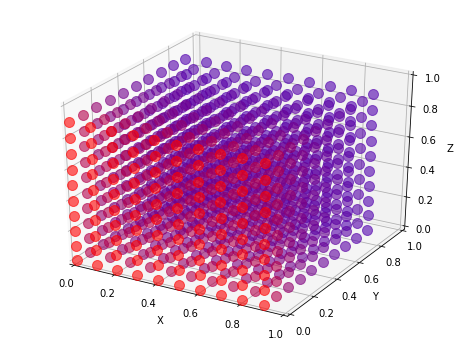

In [36]:
plotScatter3d(U_fin,1)

We now want to test if the Laplacian 3D is working, to do so we compute the necessary values

In [37]:
t_int=[0,1]
xy_int=[0,1]
nt=int((t_int[1]-t_int[0])/dt)
nxy=m
n=10
sol=LaplacianExact3d(U_fin,t_int,xy_int,nt,nxy,s)

Plotting the first iteration tensor we obtain

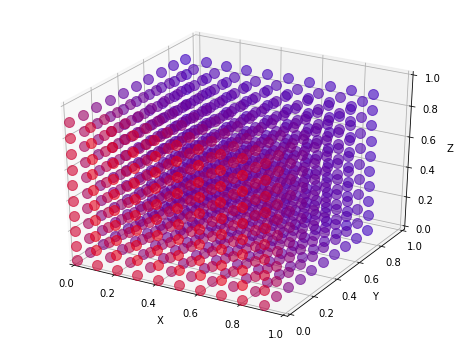

In [38]:
plotScatter3d(sol[1],1)

Plotting the fifth iteration tensor we obtain :

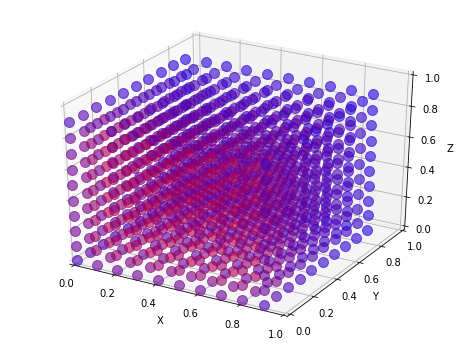

In [39]:
plotScatter3d(sol[5],1)

Plotting the tenth iteration tensor, we obtain

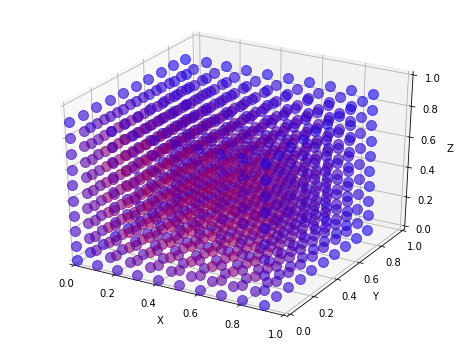

In [40]:
plotScatter3d(sol[10],1)

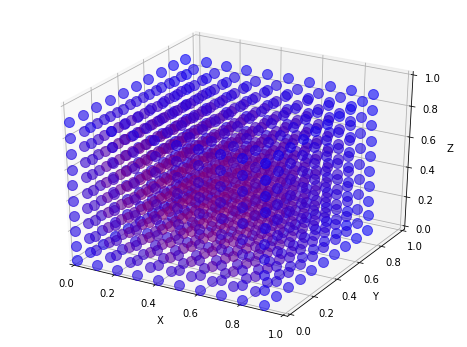

In [41]:
plotScatter3d(sol[20],1)

As we can see, we can't really see what is happening. One solution is to select only the value above a certain value and see them disappear. We fix the threeshold at val

In [42]:
def plotScatter3d_val_test(U,maximum,val):
    #Input U tensor (order 3) of shape mxnxo and maximum, the value to scale all value to, and val 
    #is the minimum value to be plotted
    #Output 3d Tensor plot
    
    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(111,projection='3d')
    
    scale=1/maximum
    
    size=U.shape
    m=size[0]
    n=size[1]
    o=size[2]
    
    for i in range(m):
        for j in range(n):
            for k in range(o):
                c=[U[i,j,k]*scale,0,scale*(1-U[i,j,k])]
                if U[i,j,k]>=val:
                    ax.plot([i], [j], [k], markerfacecolor=c, markeredgecolor=c, marker='o', markersize=10, alpha=0.6)



    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_xlim(0,m)
    ax.set_ylim(0,n)
    ax.set_zlim(0,o)


    plt.show()

Now testing with value 0.5 for the fifth slice

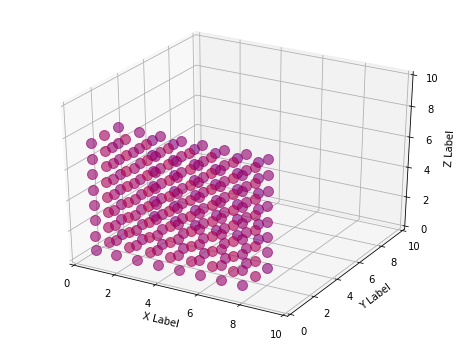

In [43]:
plotScatter3d_val_test(sol[5],1,0.5)

Testing different slices

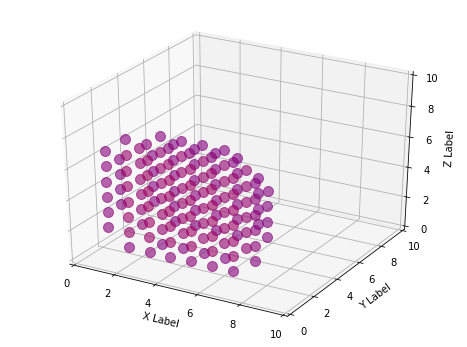

In [44]:
plotScatter3d_val_test(sol[10],1,0.5)

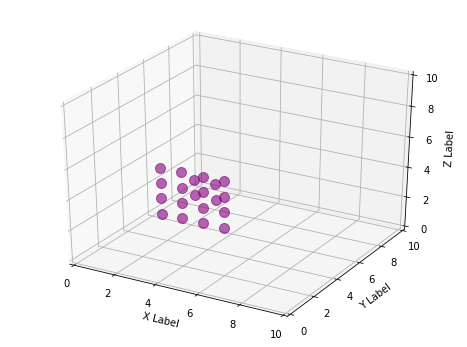

In [45]:
plotScatter3d_val_test(sol[20],1,0.5)

Now we need to adapt STA to tensor. We first uunfold the tensor, then apply STA, then reconstruct the tensor obtained.

In [46]:
def STA_tensor_algo(X_1,dim_array,rdim,mu,sigma):
    
    #INPUTS: 
    #X = tensors
    #dim_array = (k,n)x2*(dim of the tensor) = dimT*2 for dimension reduction map
    #rdim = vector of dimension of rank for the svd (troncature)
    #mu , sigma = parameter for the gaussian matrix
    #OUTPUT:
    #Core
    
    #STEP 1: getting the number of mode the tensor
    
    size=len(X_1.shape)
    
    #STEP 2: unfolding the tensor
    
    Unfolded=[]
    for i in range(0,size):
        Unfolded.append(unfold(X_1, i))
    
    #STEP 3 : creating Dim Redux
    
    #Recuperation des dimensions

    DIM=[]
    for i in range(0,len(X_1.shape)):
        DIM.append(Unfolded[i].shape)
        
    #ALGORITHME FINALE STA
    
    Reconstruct=[]

    for i in range(0,len(X_1.shape)):
        
        #matrix to apply the dim_red
        
        M=Unfolded[i]
        
        k,s=dim_array[i]
        
        #extraction of dimension reduction map from the array
        
        res=sta_algo(rdim[i],M,k,s)[1]
        
        Reconstruct.append(res[0])
        
        
    
    #RECONSTRUCTION DU TENSOR
    
    for i in range(0,3):

        C=mode_dot(X_1, np.transpose(Reconstruct[i]),i)

        X_1=C
    

    
    #RETOUR du tensor finale
    
    return(C,Reconstruct)

We then need an function to reconstruct the approximated tensor from the slice given by STA_tensor (we do a projection on each dimension)

In [47]:
def reconstruct(T, U):
    #INPUT :
    #T = tensor to approximate
    #U = matrix of reconstruction
    #mode : 0, 1, 2 
    #OUTPUT : 
    #T_tilda=tensor approximation
    
    size=len(T.shape)
    
    U_T=[]
    for i in range(0,size):
        U_T.append(np.transpose(U[i]))
    
    #reconstruction
    
    for i in range(0,size):
        alpha=U[i]@U_T[i]
        T_tilda=mode_dot(T,alpha,i)
        T=T_tilda

    
    return(T_tilda)

Adapting the Forward scheme with a randomized algorith (here **STA**) we obtain

In [48]:
def Laplacian_Euler_STA_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,dim_array,mu,sigma,f):
    #INPUTS : U is the initial condition, D is the discrete operator, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #rdim is the array containing the different rank, dim_array contains the couple kxs for the dim 
    #redux map, mu and sigma are the parameter for the dim redux, f is the tensor constant (discret
    #matrix constant)
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U_approx_slice=STA_tensor_algo(U,dim_array,rdim,mu,sigma)[1]
    
    U=reconstruct(U,U_approx_slice)
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=tensorFlatten(U)
        
        U=U+f*D@U
        
        dU=tensorReshape(U,size)
        
        dU_approx_slice=STA_tensor_algo(dU,dim_array,rdim,mu,sigma)[1]
        
        dU=reconstruct(dU,dU_approx_slice)
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

Now we want to test if it is working

In [49]:
t_int=[0,1]
xy_int=[0,1]
nt=int((t_int[1]-t_int[0])/dt)
nxy=m
n=10
f=s

rdim=[2,2,2]
dim_array=((5,8),(5,8),(5,8))
mu=0
sigma=1
D=operator3d(n)
U=U_fin

sol_sta=Laplacian_Euler_STA_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,dim_array,mu,sigma,f)

We then compute the error at every slice (each different time)

In [50]:
err_tensor=[]
for i in range(nt):
    err_tensor.append(sol[i]-sol_sta[i])

The maximum difference and the mean error is 

In [51]:
print(np.amax(err_tensor))
print(np.mean(err_tensor))

0.0002801618361650826
7.887013284346735e-07


Plotting the difference error for the tensor number 30, scaling with the mean error and setting the minimum value at 0

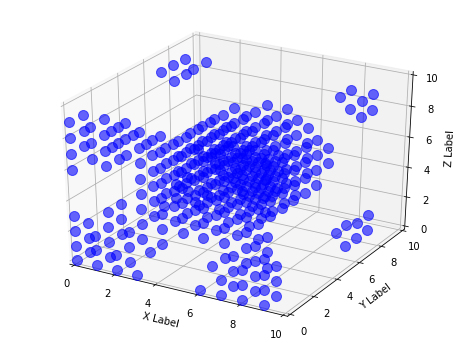

In [52]:
plotScatter3d_val_test(err_tensor[30]*np.mean(err_tensor),1,0)

Now we want to compute the difference between the SVD and the other algorithm

HOSVD

In [53]:
def hosvd(X, rank):
    #HIGH ORDER SVD ALGORITHME 1#INPUTS 
    #INPUTS 
    #X : Tensors
    #rank : Aimed Rank (array)
    #OUPUT
    #Core, Low rank approximation matrices

    #Unfolding
    A=[]
    for i in range(0,len(X.shape)):
        A.append(unfold(X, i))
    
    B=[]
    #Selection rank singular vector
    for i in range(0, len(X.shape)):
        U, D, V = np.linalg.svd(A[i], full_matrices=True, compute_uv=True)
        B.append(U[:,0:rank[i]])
    
    #reconstruction
    for i in range(0,len(X.shape)):
        C=mode_dot(X, np.transpose(B[i]),i)
        X=C
    
    return(X,B)

In [54]:
def Laplacian_Euler_hosvd_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,f):
    #INPUTS : U is the initial condition, D is the discrete operator, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #rdim is the array containing the different rank, f is the tensor constant (discret
    #matrix constant)
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size1=U.shape
    
    U_approx_sl=hosvd(U,rdim)[1]
    
    U=reconstruct(U,U_approx_sl)
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size1[0]
    
    #------------------------------------Euler
        
    for i in range(nt):
                
        U=tensorFlatten(U)
        
        A=U+f*D@U
                
        dA=tensorReshape(A,size1)
                
        dA_approx_sl=hosvd(dA,rdim)[1]
        
        dU=reconstruct(dA,dA_approx_sl)
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

HMT11

In [55]:
def hmt_rank(X,r0,a,q):
    #INPUTS : 
    #X : tensors
    #r0 : array of desired rank for troncation
    #a : parameter for dim redux matrix
    #q : power for the Htm algorithm
    
    #OUTPUT : 
    #Core, low rank approximation matrices
    

    #Unfolding of the tensors
    
    A=[]
    for i in range(0,len(X.shape)):
        A.append(unfold(X, i))
    
    svd=[]
    for i in range(0,len(X.shape)):
        svd.append(hmt_fixed_r(A[i],r0[i],a,q)[1])

    
    #Reconstruction

    for i in range(0,len(X.shape)):
        C=mode_dot(X, np.transpose(svd[i]),i)
        X=C
        
    #Resultats

    return(C,svd)

In [56]:
def Laplacian_Euler_HMT11_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,a,f,q):
    #INPUTS : U is the initial condition, D is the discrete operator, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #rdim is the array containing the different rank, dim_array contains the couple kxs for the dim 
    #redux map, f is the tensor constant (discret
    #matrix constant)
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U_approx_slice=hmt_rank(U,rdim,a,q)[1]
    
    U=reconstruct(U,U_approx_slice)
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=tensorFlatten(U)
        
        U=U+f*D@U
        
        dU=tensorReshape(U,size)
        
        dU_approx_slice=hmt_rank(dU,rdim,a,q)[1]
        
        dU=reconstruct(dU,dU_approx_slice)
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

TCYU17

In [57]:
def tcyu_tensor(X_1,dim_array,rdim,mu,sigma):
    #INPUTS: 
    #X = tensors
    #dim = (k,n)x2*(dim of the tensor) = dimT*2 for dimension reduction map
    #rdim = vector of dimension of rank for the svd (troncature)
    #mu , sigma = parameter for the gaussian matrix
    #OUTPUT:
    #Core, low rank approximation matrices
    
    #STEP 1: getting the number of mode the tensor
    
    size=len(X_1.shape)
    
    #STEP 2: unfolding the tensor
    
    Unfolded=[]
    for i in range(0,size):
        Unfolded.append(unfold(X_1, i))
    
    #STEP 3 : creating Dim Redux
    
    #Recuperation des dimensions

    DIM=[]
    for i in range(0,len(X_1.shape)):
        DIM.append(Unfolded[i].shape)
        
    #ALGORITHME FINALE STA
    
    Reconstruct=[]

    for i in range(0,len(X_1.shape)):
        
        #matrix to apply the dim_red
        
        M=Unfolded[i]
        
        k,s=dim_array[i]
        
        #extraction of dimension reduction map from the array
        
        res=tcyu(M,rdim[i],k,s)[1]
        
        Reconstruct.append(res)
    
    #RECONSTRUCTION DU TENSOR
    
    for i in range(0,3):

        C=mode_dot(X_1, np.transpose(Reconstruct[i]),i)

        X_1=C
    

    
    #RETOUR du tensor finale
    
    return(C,Reconstruct)

In [58]:
def Laplacian_Euler_tcyu17_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,dim_array,mu,sigma,f):
    #INPUTS : U is the initial condition, D is the discrete operator, t_int is the time interval, xy_int is the cube interval
    #nt is the number of element in the time grid, nxy is the number of element in one nxy grid
    #rdim is the array containing the different rank, dim_array contains the couple kxs for the dim 
    #redux map, mu and sigma are the parameter for the dim redux, f is the tensor constant (discret
    #matrix constant)
    #OUTPUTS : array of solutions
    
    #---------------------------------- set up 
    
    dt=(t_int[1]-t_int[0])/nt
    dh=(xy_int[1]-xy_int[0])/nxy
    
    #------------------------------------Flatten 
    
    size=U.shape
    
    U_approx_slice=tcyu_tensor(U,dim_array,rdim,mu,sigma)[1]
    
    U=reconstruct(U,U_approx_slice)
    
    sol=[]
    
    sol.append(U)
    
    
    #------------------------------------Creation of the operator
    
    n=size[0]
    
    #------------------------------------Euler
        
    for i in range(nt):
        
        U=tensorFlatten(U)
        
        U=U+f*D@U
        
        dU=tensorReshape(U,size)
        
        dU_approx_slice=tcyu_tensor(dU,dim_array,rdim,mu,sigma)[1]
        
        dU=reconstruct(dU,dU_approx_slice)
        
        U=dU
        
        sol.append(dU)
        
    
    return sol

List to tensor for the 4D tensor

In [59]:
def l2t(list):
    #INPUT : 
    #list : list to transform
    #OUTPUT : tensor
    
    length=len(list)
    dim=list[0].shape
    T=np.zeros((dim[0],dim[1],dim[2],length))
    for i in range(length):
        T[:,:,:,i]=list[i]
        
    return T

Plotting

In [60]:
f=s
result_sta=[]
result_svd=[]
result_hmt11=[]
result_tcyu=[]
rarray=[]

for r in range(2,10):
    
    rdim=[r,r,r]
    dim_array=((r+2,2*r+2),(r+2,2*r+2),(r+2,2*r+2))
    
    sol_svd=Laplacian_Euler_hosvd_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,f)
    sol_random=Laplacian_Euler_STA_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,dim_array,mu,sigma,f)
    sol=LaplacianExact3d(U_fin,t_int,xy_int,nt,nxy,s)
    sol_hmt11=Laplacian_Euler_HMT11_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,r+3,f,0)
    sol_tcyu17=Laplacian_Euler_tcyu17_random_tensor(U,D,t_int,xy_int,nt,nxy,rdim,dim_array,mu,sigma,f)
    
    sta_result=np.linalg.norm(l2t(sol_random)-l2t(sol))/np.linalg.norm(l2t(sol))
    svd_result=np.linalg.norm(l2t(sol_svd)-l2t(sol))/np.linalg.norm(l2t(sol))
    hmt11_result=np.linalg.norm(l2t(sol_hmt11)-l2t(sol))/np.linalg.norm(l2t(sol))
    tcyu_result=np.linalg.norm(l2t(sol_tcyu17)-l2t(sol))/np.linalg.norm(l2t(sol))
    
    result_svd.append(svd_result)
    result_sta.append(sta_result)
    result_hmt11.append(hmt11_result)
    result_tcyu.append(tcyu_result)
    rarray.append(r)

Plotting

Text(0,0.5,'relative error $err_{rel}$')

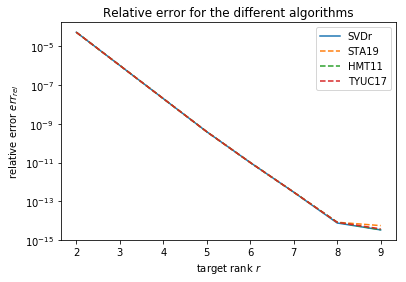

In [64]:
plt.semilogy(rarray, result_svd,label='SVDr')
plt.semilogy(rarray, result_sta,'--',label='STA19')
plt.semilogy(rarray, result_hmt11,'--',label='HMT11')
plt.semilogy(rarray, result_tcyu,'--',label='TYUC17')
plt.legend()
plt.title('Relative error for the different algorithms')
plt.xlabel('target rank $r$')
plt.ylabel('relative error $err_{rel}$')